In [1]:
from sklearn import datasets
from scipy.stats import levene, f_oneway, f
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

# ANOVA: Analysis of Variance

This notebook demonstrates how to perform and interpret Analysis of Variance (ANOVA) tests using real-world datasets. It covers:
- Formulating hypothesese
- Validating assumptions
- Interpreting results

## Introduction

Analysis of Variance (ANOVA) is a statistical test used to determine whether there are any statistically significant differences between the means of two or more independent groups. Rather than comparing group means directly, ANOVA analyzes the variation:
- Within groups (how much individual values vary inside each group)
- Between groups (how much the group means vary from each other)

By comparing these sources of variance, ANOVA helps us determine whether the observed differences in group means are likely due to real effects or just random noise.

This comparison is summarised in the F-statistic, which is the ratio of variance between groups to variance within groups. 

$$ F = \frac{Var(Between\ groups)}{Var(Within\ groups)} $$

Intuitively, if the between-group variance is large relative to the within-group variance, it suggests that the group means differ beyond what could be expected by chance.

The F-statistic follows an F-distribution, which depends on the degrees of freedom associated with the number of groups and the sample sizes. Understanding the shape of the F-distribution helps us decide how extreme an observed F-statistic must be to indicate significant differences.

Below, we visualise several F-distributions with varying degrees of freedom to illustrate how the distribution changes and what critical values might look like.

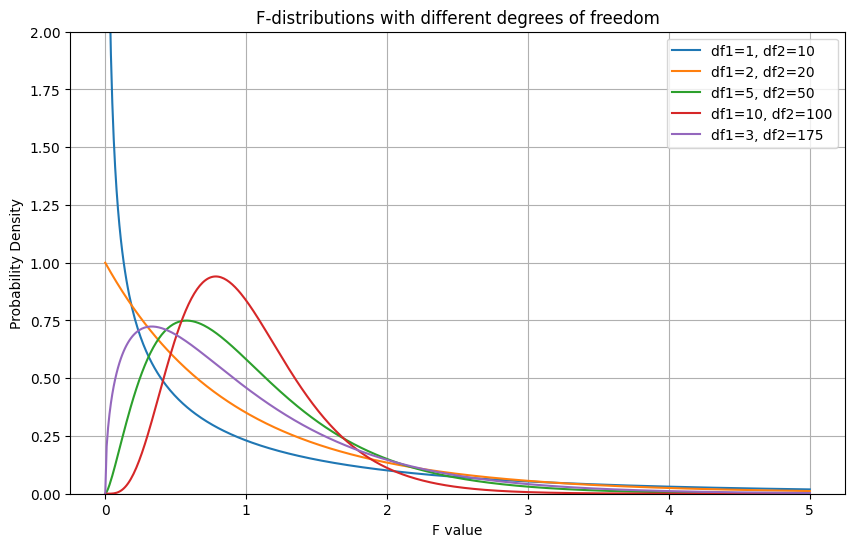

In [21]:
df_pairs = [(1, 10), (2, 20), (5, 50), (10, 100), (3, 175)]
x = np.linspace(0, 5, 500)

plt.figure(figsize=(10, 6))
plt.ylim((0, 2))

for dfn, dfd in df_pairs:
    y = f.pdf(x, dfn, dfd)
    plt.plot(x, y, label=f'df1={dfn}, df2={dfd}')

plt.title('F-distributions with different degrees of freedom')
plt.xlabel('F value')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()


## ANVOA

We will use the `wines` dataset. The target is cultivator a wine was produced by. We will examine if there is any difference in `alcohol` between the cultivators.

In [2]:
dataset = datasets.load_wine(as_frame=True)
df = dataset.frame
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


Examine the number of samples for each `target` value. 

In [3]:
df.groupby("target")["alcohol"].describe()

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0,59.0,13.744746,0.462125,12.85,13.400,13.750,14.100,14.83
1,71.0,12.278732,0.537964,11.03,11.915,12.290,12.515,13.86
2,48.0,13.153750,0.530241,12.20,12.805,13.165,13.505,14.34


Let's create boxplots to visualise the spread of `alcohol` for each of the different cultivators.

<Axes: title={'center': 'alcohol'}, xlabel='target'>

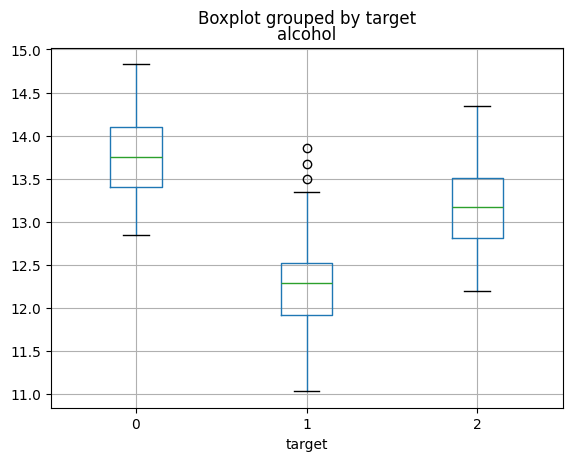

In [4]:
df.boxplot(column="alcohol", by="target")

From the above plot it is clear that wines from cultivator `1` have on average a lower `alcohol` value, and also more extreme values.

The degree of the differences observed above suggest that they are statistically significant. This is a good scenario for using an ANOVA test. We can formulate the above problem as thus:

**Hypothesis**
- $ H_0: \mu_0 = \mu_1 = \mu_2 $ (All means are equal)
- $ H_a: \text{At least one } \mu_i \neq \mu_j \text{ for some } i \neq j $ (At least one mean is different from the rest)

We shall use an alpha value of 0.05.
$$ alpha = 0.05 $$

In [5]:
group_0 = df[df["target"] == 0]["alcohol"]
group_1 = df[df["target"] == 1]["alcohol"]
group_2 = df[df["target"] == 2]["alcohol"]

Before we perform the hypothesis testing, it is important to highlight some key assumptions:
1. **Independence**
    - Observations must be independant of one another.
    - For the `wine` dataset, provided the data was collected following proper sampling procedures (e.g., different bottles, vineyards, or production batches), this assumption is reasonable. However, if there were any repeated measurements or dependencies in the sampling process, this assumption could be violated.
3. **Normality**
    - The target values within each group (`alcohol` in this case) should be roughly normally distributed. However, since each group has a sufficient number of observations (~60), the Central Limit Theorem implies that the distribution of the sample means will be approximately normal, even if the original data deviates somewhat from normality.
5. **Homoscedacity**
    - Both groups have a similar variance.

### Validating Assumptions

We will test the assumptions above. Since the assumptions for ANOVA are very similar to those for t-tests, these examples will be less detailed. For a more comprehensive use case, please refer to [T-tests](./t_tests.ipynb).

#### Independence

As stated above, this assumption is reasonably satisfied.

#### Normality

To check the normality assumption, we will use Q-Q plots.

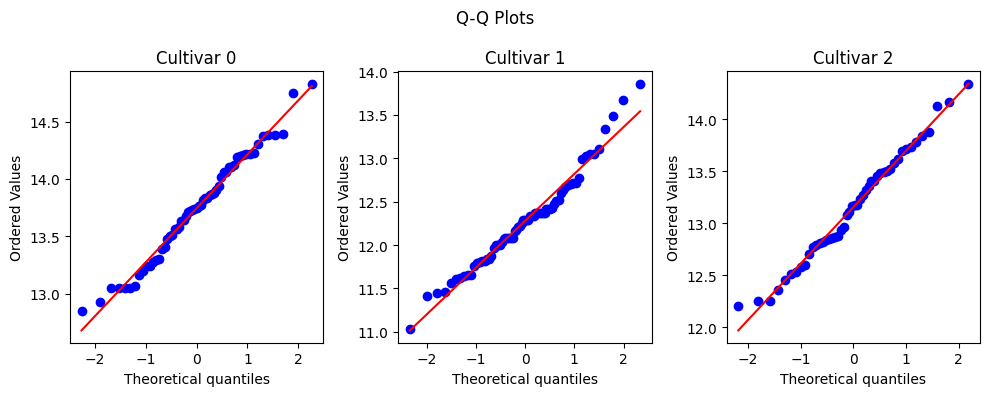

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

stats.probplot(group_0, dist="norm", plot=axs[0])
axs[0].set_title("Cultivar 0")

stats.probplot(group_1, dist="norm", plot=axs[1])
axs[1].set_title("Cultivar 1")

stats.probplot(group_2, dist="norm", plot=axs[2])
axs[2].set_title("Cultivar 2")

fig.suptitle("Q-Q Plots")
plt.tight_layout()
plt.show()

Normality observations:
- In general, the data follows the 45 degree line, indicating normality
- Cultivar `1` appears to show the most deviance from the 45 degree line. This behaviour is more extreme at the higher end (~2), suggesting slight departure from normality

From the above plots, it is safe to assume that the normality assumption holds for all 3 groups.

#### Homoscedacity

We have implicitly performed a visual insepction of homoscedacity above when examining the boxplots. Hence in this section, we shall only perform a Levene test.

In [7]:
levene_stat, levene_p_stat = levene(group_0, group_1, group_2)
print(f"Levene's test statistic: {levene_stat:.4f}")
print(f"p-value: {levene_p_stat:.4f}")

Levene's test statistic: 0.5998
p-value: 0.5501


Levene's Observations:
- A Levene’s test statistic value of 0.5998 indicates that the variance differences between the groups are small relative to the variability within each group. This suggests the groups have similar variances.
- A p-value of 0.5501 is larger than our alpha of 0.05, so we fail to reject the null hypothesis of equal variances.

The assumption of homoscedacity holds for this dataset.

#### Validating Assumptions - Conclusion

Considering the above results, all key assumptions have been reasonably met: independence, normality (supported by the Q-Q plots), and homoscedasticity (confirmed by Levene’s test). This supports the validity of the test conclusions.

### Hypothesis Testing

We shall now use `scipy` to perform a two-tailed t-test. Scipy's `f_oneway` returns two values:
1. `t-statistic`: How far the sample means are, relative to the variability in the data (larger = more significance)
2. `pvalue`: Probability in oberserving a difference at least as large as the one seen in the data

In [8]:
f_stat, p_value = f_oneway(group_0, group_1, group_2)

print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4f}")

F-statistic: 135.0776
P-value: 0.0000


Considering the above results:
- An *f-statistic* value of: 135.0776 suggests that the variance between the group means is much larger than the variance within the groups. This is strong evidence that at least one group mean differs significantly.
- A *p-value* of < 0.0001 is much smaller than our alpha of 0.05

In conclusion, based on the above ANOVA test, we **reject** the **null** hypothesis and conclude that there is statistically significant evidence to suggest that the mean alcohol content differs between at least two of the cultivar groups.

We can visualise this by plotting the F-distribution along with our F-statistic value. Due to the very large value (~135), we shall only plot $ \pm 1\% $ either side of it (This can be changed using the `perc` variable in the code block bellow).

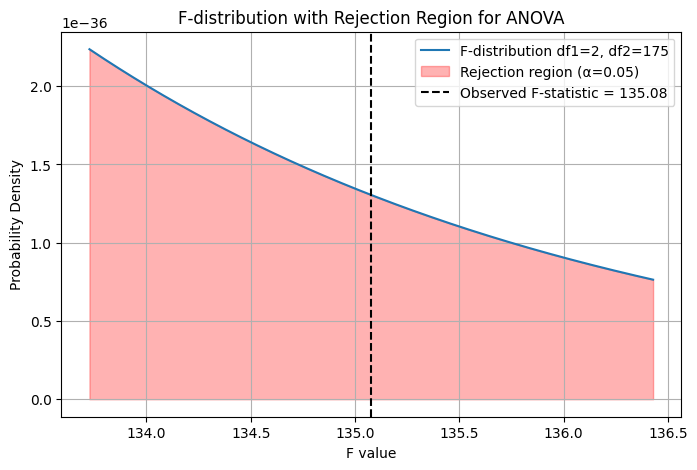

In [16]:
alpha = 0.05

# n groups - 1
df_between = 2
# n samples - n groups
df_within = len(df) - 3

perc = 0.01
x_min = f_stat * (1 - perc)
x_max = f_stat * (1 + perc)

# F-distribution PDF
x = np.linspace(x_min, x_max, 1000)
y = f.pdf(x, df_between, df_within)

# Critical F-value for rejection region (right tail)
f_crit = f.ppf(1 - alpha, df_between, df_within)

plt.figure(figsize=(8, 5))
plt.plot(x, y, label=f'F-distribution df1={df_between}, df2={df_within}')
plt.fill_between(x, 0, y, where=(x >= f_crit), color='red', alpha=0.3, label='Rejection region (α=0.05)')
plt.axvline(f_stat, color='black', linestyle='--', label='Observed F-statistic = 135.08')

plt.title('F-distribution with Rejection Region for ANOVA')
plt.xlabel('F value')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()


## Summary

This notebook demonstrated the use of ANOVA to test for differences in the mean `alcohol` content across three different wine cultivars.

- The key assumptions of ANOVA independence, normality, and equal variances, were validated through Q-Q plots and Levene’s test.
- The ANOVA F-statistic and corresponding p-value provided strong evidence to reject the null hypothesis that the means of the groups are equal.
- This indicates that at least one wine cultivar differs significantly in its mean alcohol content compared to the others.

Mastering ANOVA builds a solid foundation for analyzing differences across multiple groups and can be extended to more complex experimental designs.